In [8]:
# using GuSTO"
using JLD2, FileIO
using BenchmarkTools
include("../src/GuSTO.jl")

Forest

In [9]:
function setUpEnvironmentSphereObstacles()
    env = ISSCorner();
    add_obstacles!(env)
    return env
end

setUpEnvironmentSphereObstacles (generic function with 1 method)

In [10]:
function setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
    goal_set = GoalSet()
    addGoals!(goal_set, r_init, r_goal, q_init, q_goal, tf_guess)
    x_init = [r_init; zeros(3); q_init; zeros(3)]
    PD = ProblemDefinition(robot, model, env, x_init, goal_set);
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end

setUpProblemAllParams (generic function with 1 method)

In [11]:
function addGoals!(goal_set, r_init, r_goal, q_init, q_goal, tf_guess)
    q_goal = q_goal/norm(q_goal)
    x_init = [r_init; zeros(3); q_init; zeros(3)]
    v_goal = zeros(3)
    ω_goal = zeros(3)

    x_goal = [r_goal; v_goal; q_goal; ω_goal]
    # add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))

    ε = 1e-4
    add_goal!(goal_set, Goal(PointGoal(r_goal), tf_guess, 1:3))
    add_goal!(goal_set, Goal(PointGoal(v_goal), tf_guess, 4:6))
    add_goal!(goal_set, Goal(BoxGoal(q_goal.-ε, q_goal.+ε), tf_guess, 7:10))
    # add_goal!(goal_set, Goal(PointGoal(q_goal), tf_guess, 7:10))
    add_goal!(goal_set, Goal(PointGoal(ω_goal), tf_guess, 11:13))
end

addGoals! (generic function with 1 method)

In [175]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec, dual_vec = nothing)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'
    if dual_vec != nothing
        dual_row = hcat((map(a -> a[:], dual_vec))...)'
    end
#     @show(size(ω_vec))
#     @show(size(X_row))
    if dual_vec == nothing
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]
    else
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec, dual_row)[1:end-1,:]
    end

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    if dual_vec == nothing
        train_output = hcat(diff_X_row, diff_U_row)
    else
        train_output = hcat(diff_X_row, diff_U_row, dual_row[2:end, :])
    end
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 2 methods)

In [176]:
function checkIfInISS(r, env)
    # Must be INSIDE any keep in
    # Must be OUTSIDE all keep out - ignoring this one for now
    # Must be OUTSIDE all obstacles
    inside_keepin = false
    for z in env.keepin_zones
        maxVals = z.origin + z.widths
        minVals = z.origin - z.widths
        if (all(r.<maxVals) && all(r.>minVals))
            inside_keepin = true
            break # Inside ANY is pass
        end
    end
    if !inside_keepin
        return false
    end
    
#     inside_keepout = false
#     for z in env.keepout_zones
#         maxVals = z.origin + z.widths
#         minVals = z.origin - z.widths
#         if (all(r.<maxVals) && all(r.>minVals))
#             inside_keepout = true
#             break # If inside ANY then we fail
#         end
#     end
#     if inside_keepout
#         println("Is inside some keep out zones")
#         return false
#     end
    
    for o in env.obstacle_set
        dist_from_center = norm(r - o.center)
        if dist_from_center < o.r
            return false
        end
    end
    
    return true
end

checkIfInISS (generic function with 1 method)

# Time one iteration of GuSTO

In [40]:
time_start = time_ns()

env = setUpEnvironmentSphereObstacles()
N = 50
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
tf_guess = 10.

# Pick the init and goal positions
# Small corner maneuver
r_init = [11.2; -0.8; 5.6]
r_goal = [10.9; 3.0; 5.0]
q_init = [1.; 0.; 0.; 0.]
q_goal = [0.; 1.; 0.; 0.]
v_goal = zeros(3)
ω_goal = zeros(3)
x_goal = [r_goal; v_goal; q_goal; ω_goal]

max_iter = 10

TOP, TOSgusto = setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
traj_init = init_traj_straightline(TOP)

traj_X_vec = [traj_init.X] 
traj_U_vec = [traj_init.U]
traj_X_vec_first_only = [traj_init.X]
traj_U_vec_first_only = [traj_init.U]
dual_vec = [zeros(13)]

gusto_setup_time = (time_ns() - time_start)/10^9
println("Setup time $gusto_setup_time")

# Solve one step at a time with IPOPT
time_start = time_ns()
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
gusto_solve_time = (time_ns() - time_start)/10^9
println("Solve time $gusto_solve_time")

repTime = TOSgusto.SCPS.total_time
println("Time reported $repTime")



Setup time 0.011667612
Solve time 0.324160752
Time reported 0.309949297


In [41]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = false
(TOSgusto.SCPS).iterations = 1
(TOSgusto.SCPS).total_time = 0.309949297
(TOSgusto.SCPS).accept_solution = Bool[true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.0853259]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 5.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [1000.0, 1000.0]
(TOSgusto.SCPS).J_true = Any[0.0, 62.31]
(TOSgusto.SCPS).dual = [-1.90918, 111.071, -22.2502, -31.7574, 725.764, -136.02, -0.0022551, 0.00225565, -8.55444e-25, -7.53051e-24, 0.00563868, 4.84658e-24, -1.32658e-23]


# Time all iterations of GuSTO

In [108]:
time_start = time_ns()

env = setUpEnvironmentSphereObstacles()
N = 100
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
tf_guess = 100.

# Pick the init and goal positions
# Small corner maneuver
r_init = [11.2; -0.8; 5.6] # small corner
r_init = [9.2; -0.1; 5.6] # This works. Keep y at -0.1 and vary x from ?? up to 11.2
r_init = [8.5; -0.1; 5.6] # z is too high! Doesn't work
r_init = [8.5; -0.1; 4.6]
r_goal = [10.9; 3.0; 5.0]
q_init = [1.; 0.; 0.; 0.]
q_goal = [0.; 1.; 0.; 0.]
v_goal = zeros(3)
ω_goal = zeros(3)
x_goal = [r_goal; v_goal; q_goal; ω_goal]

TOP, TOSgusto = setUpProblemAllParams(N, r_init, r_goal, q_init, q_goal, robot, model, env, tf_guess)
traj_init = init_traj_straightline(TOP)

traj_X_vec = [traj_init.X] 
traj_U_vec = [traj_init.U]
traj_X_vec_first_only = [traj_init.X]
traj_U_vec_first_only = [traj_init.U]
dual_vec = [zeros(13)]

gusto_setup_time = (time_ns() - time_start)/10^9
println("Setup time $gusto_setup_time")

# Solve one step at a time with IPOPT
time_start = time_ns()
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=10, print_level=0);
gusto_solve_time = (time_ns() - time_start)/10^9
println("Solve time $gusto_solve_time")

repTime = TOSgusto.SCPS.total_time
println("Time reported $repTime")



Setup time 0.011525934
Solve time 7.379851983
Time reported 7.367700549


In [186]:
count = 0
for x in range(env.worldAABBmin[1], stop= env.worldAABBmax[1], length = 100)
    for y in range(env.worldAABBmin[2], stop= env.worldAABBmax[2], length = 100)
        for z in range(env.worldAABBmin[3], stop= env.worldAABBmax[3], length = 100)
            r = [x, y, z]
            if checkIfInISS(r, env)
                count = count +1
            end
        end
    end
end
println("$count")

40321


In [188]:
for i in 1:4
    println("$i")
end

1
2
3
4


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")

In [151]:
typeof(env.keepin_zones[1])
h = env.keepin_zones[1]
h.origin
h.widths
@show env.worldAABBmin
@show env.worldAABBmax
env.keepout_zones
env.obstacle_set
o = env.obstacle_set[1]
o.center
o.r

env.worldAABBmin = [-7.40737, -12.7575, -6.38499]
env.worldAABBmax = [22.0844, 17.3351, 16.0576]


0.4f0

In [152]:
a = [1.3, 2.3, 3.4]
typeof(a)
b = [1.3, 2.1, 3.1]
b.<a
all(b.<a)
norm(b)

3.963584236521283

In [174]:
r = [11.2; -0.8; 5.6]
r = [9.2; -0.1; 5.6]
r = [-9.5; -0.1; 5.6]
r = [8.5; -0.1; 4.6]
# r = [21.0, -10.0, -5.0]
checkIfInISS(r, env)

true

checkIfInISS (generic function with 1 method)

In [110]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 10
(TOSgusto.SCPS).total_time = 7.367700549
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true, true, true, true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).convergence_measure = [0.0, 0.0862169, 0.0316535, 0.0069407, 0.00460227, 0.00413383, 0.00133496, 0.00297484, 0.000578852, 3.6661e-5, 3.07603e-6]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(((TOSgusto.SCPS).param).alg).Δ_vec = [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
(TOSgusto.SCPS).J_true = Any[0.0, 0.0527407, 0.0179525, 0.017594, 0.017239, 0.0170

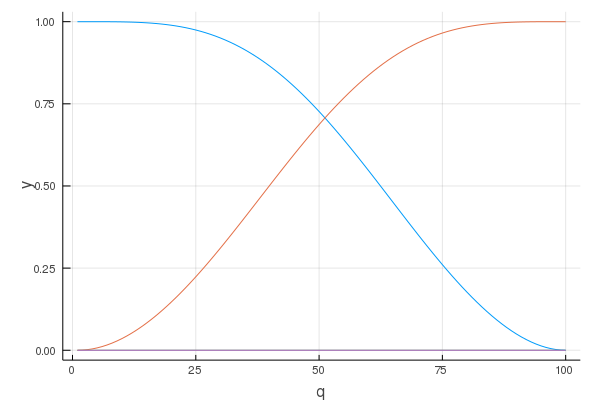

In [111]:
using Plots
gr(fmt=:png)
plot()
for i = 7:10
    plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[i,:]],
        xlabel = "q",
        ylabel = "y",
        legend = :none)
end
plot!()

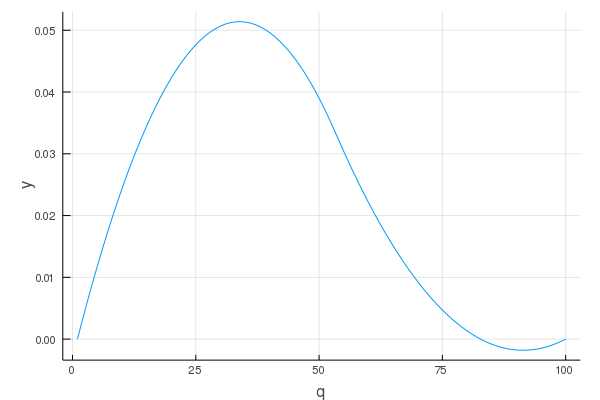

In [112]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[4,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

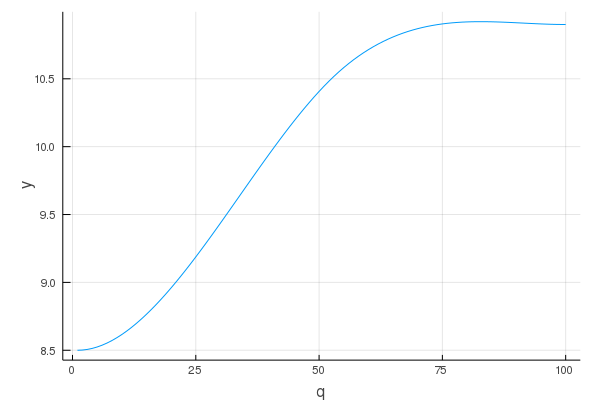

In [113]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOSgusto.SCPS.traj.X[1,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

In [114]:
using AstrobeeRobot

# Animate Astrobee trajectory
vis = Visualizer()
delete!(vis)

vis[:goal]
for (idx,obs) in enumerate(env.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3f0(x_goal[1:3]), 0.1f0),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
end

vis[:workspace]
for (idx,ws) in enumerate(env.keepin_zones)
    if idx in (5,8)
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
    else
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
    end
end

vis[:obstacle]
for (idx,ws) in enumerate(env.obstacle_set)
    setobject!(vis[:workspace][Symbol(string("ws",idx+length(env.keepin_zones)))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
end

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

speed_factor = 3

Qs = Vector{Vector{Float64}}()
for k in 1:speed_factor:N
#     q = [quat_inv(TOS_SCP.SCPS.traj.X[7:10,k]); TOS_SCP.SCPS.traj.X[1:3,k]]
    q = [quat_inv(TOSgusto.SCPS.traj.X[7:10,k]); TOSgusto.SCPS.traj.X[1:3,k]]
    push!(Qs,q)
end

trans = Translation(14., -1., 7.)
rot = LinearMap(RotZ(-0.6)) ∘ LinearMap(RotY(-0.2))
settransform!(vis["/Cameras/default"], trans ∘ rot)
setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1.9)
setprop!(vis["/Cameras/default/rotated/<object>"], "near", 0.05)

sleep(3)
setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)

instantiated a floating joint


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8705
└ @ MeshCat /home/freeflyerhub/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8705`, ProcessExited(0))